# Cifar classification with CNN

* [Libraries](#section-one)
* [Dataset](#section-two)
    - [Exploratory analysis](#subsection-one)
* [Data Cleaning](#section-three)
* [Training](#section-four)
* [Results](#section-five)

In [2]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,Flatten, Dense, Dropout, Activation
from tensorflow.keras.datasets import cifar10
from tqdm.keras import TqdmCallback

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 5s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

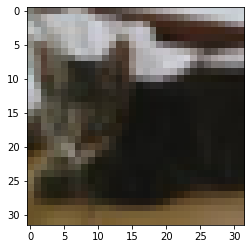

In [6]:
plt.imshow(X_train[9])

# Data cleaning

In [7]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [8]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Batch normalization

- Small values: Usually between 0 and 1
- Homogeneous data: Every pixel have the same range

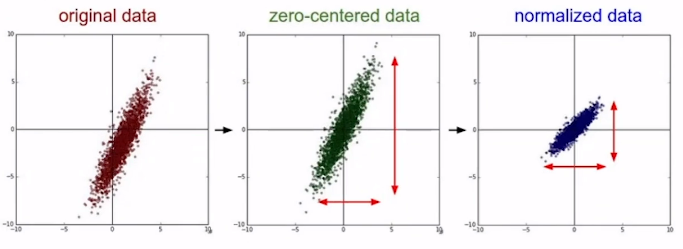

It helps a lot to optimizers

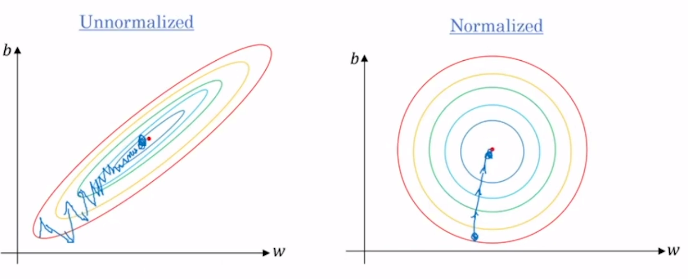

What is batch normalization? Well it's a kind of normalization made on nn's layers

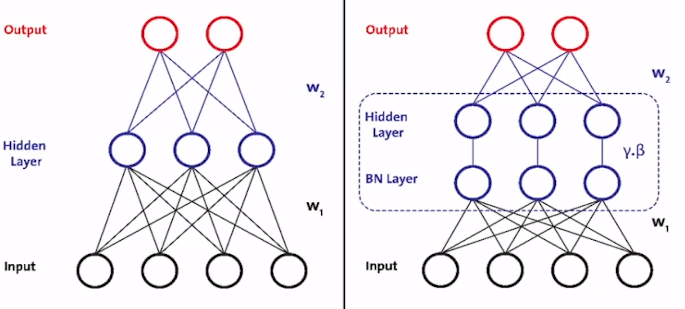

## Math behind

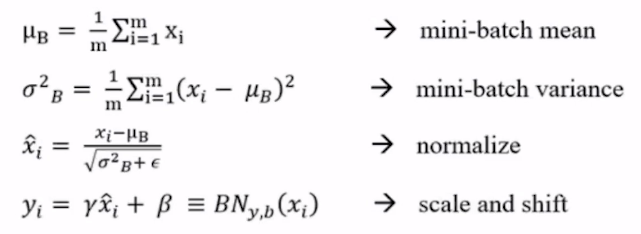

## Implementation of batch normalization

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

In [10]:
# Data normalization
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / (std+1e-8)
X_test = (X_test - mean) / (std+1e-8)  # Ethics

## Breaking the data up

In [11]:
(X_train, X_valid) = X_train[5000:], X_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [12]:
print('x_train shape ', X_train.shape)

print('train shape ', X_train.shape[0])
print('val shape ', X_valid.shape[0])
print('test shape ', X_test.shape[0])

x_train shape  (45000, 32, 32, 3)
train shape  45000
val shape  5000
test shape  10000


# Training

In [13]:
filters_base = 64
w_regularizer = 1e-4

In [14]:
X_train.shape[1:]

(32, 32, 3)

## Convolutional Neural Network architecture

In [15]:
# Model

model = Sequential()

## conv 1
model.add(Conv2D(filters_base, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

## conv 2
model.add(Conv2D(filters_base, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## conv 3
model.add(Conv2D(2*filters_base, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

## conv 4
model.add(Conv2D(2*filters_base, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## conv 5
model.add(Conv2D(4*filters_base, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())


## conv 6
model.add(Conv2D(4*filters_base, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

## Clasificacion - Flatten

model.add(Flatten())
model.add(Dense(num_classes,activation='softmax'))

2022-11-04 16:13:56.265138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 16:13:56.266093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 16:13:56.431437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 16:13:56.432325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 16:13:56.433124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 64)        0

## Data augmentation

In [17]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Fitting the model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
from tensorflow.keras import optimizers 

In [20]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy']
)

In [21]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [22]:
early = EarlyStopping(monitor='val_accuracy', patience=20)

In [23]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    verbose=0,
    callbacks=[TqdmCallback(verbose=1), early, checkpoint],
    steps_per_epoch = X_train.shape[0] // 128,  # train set length
    epochs = 120,
    validation_data = (X_valid, y_valid)
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-11-04 16:14:01.076074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-04 16:14:04.493950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00001: val_accuracy improved from -inf to 0.27440, saving model to best_model.hdf5

Epoch 00002: val_accuracy improved from 0.27440 to 0.49960, saving model to best_model.hdf5

Epoch 00003: val_accuracy did not improve from 0.49960

Epoch 00004: val_accuracy improved from 0.49960 to 0.56840, saving model to best_model.hdf5

Epoch 00005: val_accuracy improved from 0.56840 to 0.58140, saving model to best_model.hdf5

Epoch 00006: val_accuracy improved from 0.58140 to 0.62860, saving model to best_model.hdf5

Epoch 00007: val_accuracy improved from 0.62860 to 0.64620, saving model to best_model.hdf5

Epoch 00008: val_accuracy did not improve from 0.64620

Epoch 00009: val_accuracy improved from 0.64620 to 0.64760, saving model to best_model.hdf5

Epoch 00010: val_accuracy improved from 0.64760 to 0.70260, saving model to best_model.hdf5

Epoch 00011: val_accuracy improved from 0.70260 to 0.73240, saving model to best_model.hdf5

Epoch 00012: val_accuracy did not improve from 0.7324

In [43]:
best_model = model
best_model.load_weights('./best_model.hdf5')

In [45]:
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6975 - accuracy: 0.8521


[0.6975417733192444, 0.8521000146865845]

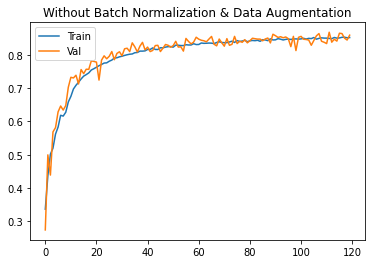

In [46]:
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Val')
plt.title('Without Batch Normalization & Data Augmentation')
plt.legend()
plt.show()